In [ ]:

import torch
print(f"GPU: {torch.cuda.is_available()}")


GPU: True


In [ ]:
# Installation des dépendances
!pip install transformers torch rouge-score sentencepiece -q

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Itération 4 : Approche Hybride (TextRank + T5)

In [ ]:
"""
Projet RCP217 - Génération de résumés CNN
Itération 4 : Approche Hybride (TextRank + T5)

Objectif : Combiner extraction (pré-filtre) + abstraction (reformulation)
pour améliorer qualité et réduire hallucinations
"""

import os
import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==========================================
# CONFIGURATION
# ==========================================

class HybridConfig:
    """Configuration pour approche hybride"""

    # Chemins
    PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

    # Phase extractive (TextRank)
    COMPRESSION_RATIO = 0.4      # Garder 40% des phrases
    MIN_SENTENCES = 5            # Minimum 5 phrases
    MAX_SENTENCES = 10           # Maximum 10 phrases
    SIMILARITY_THRESHOLD = 0.0   # Seuil similarité TextRank

    # Phase abstractive (T5)
    T5_MODEL_PATH = f'{PROJECT_DIR}/models/t5_small_phase2_best'  # Modèle fine-tuné
    MAX_INPUT_LENGTH = 512       # T5 peut traiter plus avec compression
    MAX_OUTPUT_LENGTH = 128
    NUM_BEAMS = 4

    # Évaluation
    EVAL_SIZE = 1000             # Nombre d'exemples à évaluer

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def print_config():
        print("\n⚙️  CONFIGURATION APPROCHE HYBRIDE")
        print("="*60)
        print(f"Compression ratio   : {HybridConfig.COMPRESSION_RATIO} (40% phrases)")
        print(f"Sentences range     : {HybridConfig.MIN_SENTENCES}-{HybridConfig.MAX_SENTENCES}")
        print(f"T5 model            : {HybridConfig.T5_MODEL_PATH.split('/')[-1]}")
        print(f"Device              : {HybridConfig.DEVICE}")
        print(f"Eval size           : {HybridConfig.EVAL_SIZE} exemples")
        print("="*60)


# ==========================================
# PARTIE 1 : COMPOSANT EXTRACTIF (TextRank)
# ==========================================

class TextRankExtractor:
    """
    Extracteur TextRank pour la phase de pré-sélection
    Réutilise l'implémentation de l'Itération 1
    """

    def __init__(self, similarity_threshold=0.0):
        self.similarity_threshold = similarity_threshold
        self.vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            max_features=5000
        )

    def _build_similarity_matrix(self, sentences):
        """Construit la matrice de similarité entre phrases"""
        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
            similarity_matrix[similarity_matrix < self.similarity_threshold] = 0
            return similarity_matrix
        except:
            return np.zeros((len(sentences), len(sentences)))

    def extract_key_sentences(self, text, n_sentences=None, compression_ratio=0.4):
        """
        Extrait les phrases clés d'un article

        Args:
            text: article complet
            n_sentences: nombre de phrases à extraire (None = auto)
            compression_ratio: ratio de compression si n_sentences=None

        Returns:
            Liste de phrases extraites (dans l'ordre original)
        """
        # Tokenization en phrases
        sentences = sent_tokenize(text)

        # Déterminer nombre de phrases à extraire
        if n_sentences is None:
            n_sentences = max(
                HybridConfig.MIN_SENTENCES,
                min(HybridConfig.MAX_SENTENCES, int(len(sentences) * compression_ratio))
            )

        # Cas limite
        if len(sentences) <= n_sentences:
            return sentences

        # Construction matrice de similarité
        similarity_matrix = self._build_similarity_matrix(sentences)

        # PageRank
        nx_graph = nx.from_numpy_array(similarity_matrix)

        try:
            scores = nx.pagerank(nx_graph, max_iter=100)
        except:
            # Si PageRank échoue, scores uniformes
            scores = {i: 1.0 for i in range(len(sentences))}

        # Sélection top-N dans ordre original
        ranked_sentences = sorted(
            ((scores[i], i, s) for i, s in enumerate(sentences)),
            reverse=True
        )

        top_indices = sorted([idx for _, idx, _ in ranked_sentences[:n_sentences]])
        key_sentences = [sentences[i] for i in top_indices]

        return key_sentences


# ==========================================
# PARTIE 2 : COMPOSANT ABSTRACTIF (T5)
# ==========================================

class T5AbstractiveGenerator:
    """
    Générateur abstractif T5 pour la phase de reformulation
    Utilise le modèle fine-tuné de l'Itération 2
    """

    def __init__(self, model_path, device):
        self.device = device
        print(f"\n🔧 Chargement du modèle T5 fine-tuné...")
        self.tokenizer = T5Tokenizer.from_pretrained(model_path)
        self.model = T5ForConditionalGeneration.from_pretrained(model_path)
        self.model.to(device)
        self.model.eval()
        print(f"✅ Modèle chargé : {model_path}")

    def generate_summary(self, text, max_input_length=512, max_output_length=128, num_beams=4):
        """
        Génère un résumé abstractif du texte

        Args:
            text: texte à résumer (déjà compressé par TextRank)

        Returns:
            Résumé généré
        """
        # Préfixe T5
        source_text = f"summarize: {text}"

        # Tokenization
        inputs = self.tokenizer(
            source_text,
            max_length=max_input_length,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        # Génération
        with torch.no_grad():
            summary_ids = self.model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_output_length,
                min_length=30,
                num_beams=num_beams,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        # Décodage
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        return summary


# ==========================================
# PARTIE 3 : PIPELINE HYBRIDE
# ==========================================

class HybridSummarizer:
    """
    Pipeline hybride combinant TextRank (extraction) et T5 (abstraction)
    """

    def __init__(self, config):
        self.config = config

        print("\n🚀 INITIALISATION PIPELINE HYBRIDE")
        print("="*60)

        # Composant 1 : Extracteur
        print("Étape 1/2 : Initialisation TextRank...")
        self.extractor = TextRankExtractor(
            similarity_threshold=config.SIMILARITY_THRESHOLD
        )
        print("✅ TextRank prêt")

        # Composant 2 : Générateur
        print("\nÉtape 2/2 : Chargement T5...")
        self.generator = T5AbstractiveGenerator(
            model_path=config.T5_MODEL_PATH,
            device=config.DEVICE
        )
        print("✅ T5 prêt")

        print("\n" + "="*60)
        print("✨ Pipeline hybride initialisé avec succès!")
        print("="*60)

    def summarize(self, article):
        """
        Génère un résumé hybride en deux étapes

        Args:
            article: texte complet de l'article

        Returns:
            dict avec résumé final + informations intermédiaires
        """
        # ÉTAPE 1 : Extraction (pré-filtre)
        key_sentences = self.extractor.extract_key_sentences(
            article,
            compression_ratio=self.config.COMPRESSION_RATIO
        )
        compressed_article = ' '.join(key_sentences)

        # Statistiques de compression
        original_words = len(article.split())
        compressed_words = len(compressed_article.split())
        compression_rate = compressed_words / original_words if original_words > 0 else 0

        # ÉTAPE 2 : Abstraction (reformulation)
        final_summary = self.generator.generate_summary(
            compressed_article,
            max_input_length=self.config.MAX_INPUT_LENGTH,
            max_output_length=self.config.MAX_OUTPUT_LENGTH,
            num_beams=self.config.NUM_BEAMS
        )

        return {
            'summary': final_summary,
            'key_sentences': key_sentences,
            'n_sentences_extracted': len(key_sentences),
            'original_length': original_words,
            'compressed_length': compressed_words,
            'compression_rate': compression_rate
        }

    def summarize_batch(self, articles):
        """
        Génère des résumés pour un batch d'articles

        Args:
            articles: liste d'articles

        Returns:
            Liste de résumés + statistiques
        """
        results = []

        for article in tqdm(articles, desc="Génération résumés hybrides"):
            result = self.summarize(article)
            results.append(result)

        return results


# ==========================================
# PARTIE 4 : ÉVALUATION ET COMPARAISON
# ==========================================

class HybridEvaluator:
    """Évaluateur pour comparer les 3 approches"""

    def __init__(self):
        self.scorer = rouge_scorer.RougeScorer(
            ['rouge1', 'rouge2', 'rougeL'],
            use_stemmer=True
        )

    def evaluate(self, predictions, references):
        """Calcule les scores ROUGE"""
        all_scores = []

        for pred, ref in tqdm(zip(predictions, references),
                              total=len(predictions),
                              desc="Évaluation ROUGE"):
            if isinstance(ref, list):
                ref_text = ' '.join(ref)
            else:
                ref_text = ref

            scores = self.scorer.score(ref_text, pred)

            all_scores.append({
                'rouge1_f': scores['rouge1'].fmeasure,
                'rouge2_f': scores['rouge2'].fmeasure,
                'rougeL_f': scores['rougeL'].fmeasure,
            })

        results_df = pd.DataFrame(all_scores)
        mean_scores = results_df.mean()

        return results_df, mean_scores

    def compare_approaches(self, extractive_scores, abstractive_scores, hybrid_scores):
        """
        Compare les 3 approches visuellement

        Args:
            extractive_scores: dict avec ROUGE extractif
            abstractive_scores: dict avec ROUGE abstractif
            hybrid_scores: dict avec ROUGE hybride
        """
        print("\n" + "="*70)
        print("📊 COMPARAISON DES TROIS APPROCHES")
        print("="*70)

        # Tableau comparatif
        metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
        extractive = [extractive_scores['rouge1'],
                      extractive_scores['rouge2'],
                      extractive_scores['rougeL']]
        abstractive = [abstractive_scores['rouge1'],
                       abstractive_scores['rouge2'],
                       abstractive_scores['rougeL']]
        hybrid = [hybrid_scores['rouge1_f'],
                  hybrid_scores['rouge2_f'],
                  hybrid_scores['rougeL_f']]

        print("\n| Métrique  | Extractif | Abstractif | Hybride | Meilleur    |")
        print("|-----------|-----------|------------|---------|-------------|")

        for metric, ext, abs_t5, hyb in zip(metrics, extractive, abstractive, hybrid):
            best_score = max(ext, abs_t5, hyb)

            if best_score == ext:
                best_label = "Extractif ⭐"
            elif best_score == abs_t5:
                best_label = "Abstractif ⭐"
            else:
                best_label = "Hybride ⭐"

            print(f"| {metric:<9} | {ext:.4f}    | {abs_t5:.4f}     | {hyb:.4f}  | {best_label} |")

        # Graphique comparatif
        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(metrics))
        width = 0.25

        bars1 = ax.bar(x - width, extractive, width, label='Extractif (TextRank)',
                       alpha=0.8, color='#3498db')
        bars2 = ax.bar(x, abstractive, width, label='Abstractif (T5)',
                       alpha=0.8, color='#e74c3c')
        bars3 = ax.bar(x + width, hybrid, width, label='Hybride (TextRank+T5)',
                       alpha=0.8, color='#2ecc71')

        ax.set_xlabel('Métrique ROUGE', fontsize=12)
        ax.set_ylabel('F1-Score', fontsize=12)
        ax.set_title('Comparaison des trois approches de résumé', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim(0, max(max(extractive), max(abstractive), max(hybrid)) * 1.1)

        # Ajouter valeurs sur barres
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig('comparison_three_approaches.png', dpi=300, bbox_inches='tight')
        print("\n📊 Graphique sauvegardé : comparison_three_approaches.png")
        plt.show()

        # Analyse des gains
        print("\n📈 ANALYSE DES GAINS")
        print("="*70)

        hybrid_vs_extractive = ((hybrid[0] - extractive[0]) / extractive[0]) * 100
        hybrid_vs_abstractive = ((hybrid[0] - abstractive[0]) / abstractive[0]) * 100

        print(f"\nHybride vs Extractif   : {hybrid_vs_extractive:+.1f}% (ROUGE-1)")
        print(f"Hybride vs Abstractif  : {hybrid_vs_abstractive:+.1f}% (ROUGE-1)")

        if hybrid[0] > max(extractive[0], abstractive[0]):
            print("\n✅ L'approche hybride SURPASSE les deux approches individuelles!")
            print("   → La combinaison extraction+abstraction apporte un gain tangible")
        elif hybrid[0] > extractive[0]:
            print("\n✅ L'hybride améliore la baseline extractive")
            print("   → Mais reste légèrement en-dessous de l'abstractif pur")
        else:
            print("\n⚠️  L'hybride n'apporte pas de gain significatif")
            print("   → L'abstractif T5 seul reste la meilleure approche")


# ==========================================
# PARTIE 5 : EXEMPLES QUALITATIFS
# ==========================================

def show_hybrid_examples(df, hybrid_results, n=3, seed=42):
    """
    Affiche des exemples comparatifs des 3 approches

    Args:
        df: DataFrame avec articles et résumés de référence
        hybrid_results: résultats hybrides avec informations intermédiaires
    """
    print("\n" + "="*80)
    print("📝 EXEMPLES QUALITATIFS - COMPARAISON DES TROIS APPROCHES")
    print("="*80)

    # Generate random positional indices for sampling
    np.random.seed(seed) # Ensure reproducibility
    sampled_positional_indices = np.random.choice(len(df), n, replace=False)
    sampled_positional_indices.sort() # Sort to display examples in a consistent order

    for i, pos_idx in enumerate(sampled_positional_indices, 1):
        # Access DataFrame using .iloc for positional indexing
        row = df.iloc[pos_idx]
        # Access hybrid_results list using the same positional index
        hybrid_res = hybrid_results[pos_idx]

        print(f"\n{'─'*80}")
        print(f"EXEMPLE {i}")
        print(f"{'─'*80}")

        print(f"\n📰 ARTICLE ORIGINAL ({len(row['article'].split())} mots):")
        print(f"{row['article'][:300]}...\n")

        print(f"🔍 PHRASES CLÉS EXTRAITES (TextRank, {hybrid_res['n_sentences_extracted']} phrases):")
        for j, sent in enumerate(hybrid_res['key_sentences'][:3], 1):
            print(f"  {j}. {sent}")
        if len(hybrid_res['key_sentences']) > 3:
            print(f"  ... ({len(hybrid_res['key_sentences']) - 3} autres phrases)")
        print(f"\n  → Compression: {hybrid_res['original_length']} → {hybrid_res['compressed_length']} mots ({hybrid_res['compression_rate']*100:.0f}%)")

        print(f"\n🤖 RÉSUMÉ HYBRIDE (TextRank + T5):")
        print(f"{hybrid_res['summary']}\n")

        print(f"✅ RÉSUMÉ RÉFÉRENCE:")
        for j, highlight in enumerate(row['highlights'], 1):
            print(f"  {j}. {highlight}")


#IT4-Main script

🚀 ITÉRATION 4 : APPROCHE HYBRIDE (TextRank + T5)

⚙️  CONFIGURATION APPROCHE HYBRIDE
Compression ratio   : 0.4 (40% phrases)
Sentences range     : 5-10
T5 model            : t5_small_phase2_best
Device              : cuda
Eval size           : 1000 exemples

📂 CHARGEMENT DES DONNÉES
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Évaluation sur 1000 exemples (test set)

🚀 INITIALISATION PIPELINE HYBRIDE
Étape 1/2 : Initialisation TextRank...
✅ TextRank prêt

Étape 2/2 : Chargement T5...

🔧 Chargement du modèle T5 fine-tuné...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Modèle chargé : /content/drive/MyDrive/RCP217_Projet_Summarization/models/t5_small_phase2_best
✅ T5 prêt

✨ Pipeline hybride initialisé avec succès!

📝 GÉNÉRATION DES RÉSUMÉS HYBRIDES


Génération résumés hybrides: 100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]



📊 ÉVALUATION ROUGE


Évaluation ROUGE: 100%|██████████| 1000/1000 [00:01<00:00, 694.87it/s]



🎯 RÉSULTATS HYBRIDE:
  ROUGE-1: 0.3287
  ROUGE-2: 0.1171
  ROUGE-L: 0.2242

📊 COMPARAISON DES TROIS APPROCHES

| Métrique  | Extractif | Abstractif | Hybride | Meilleur    |
|-----------|-----------|------------|---------|-------------|
| ROUGE-1   | 0.2941    | 0.3489     | 0.3287  | Abstractif ⭐ |
| ROUGE-2   | 0.0927    | 0.1368     | 0.1171  | Abstractif ⭐ |
| ROUGE-L   | 0.1885    | 0.2425     | 0.2242  | Abstractif ⭐ |

📊 Graphique sauvegardé : comparison_three_approaches.png


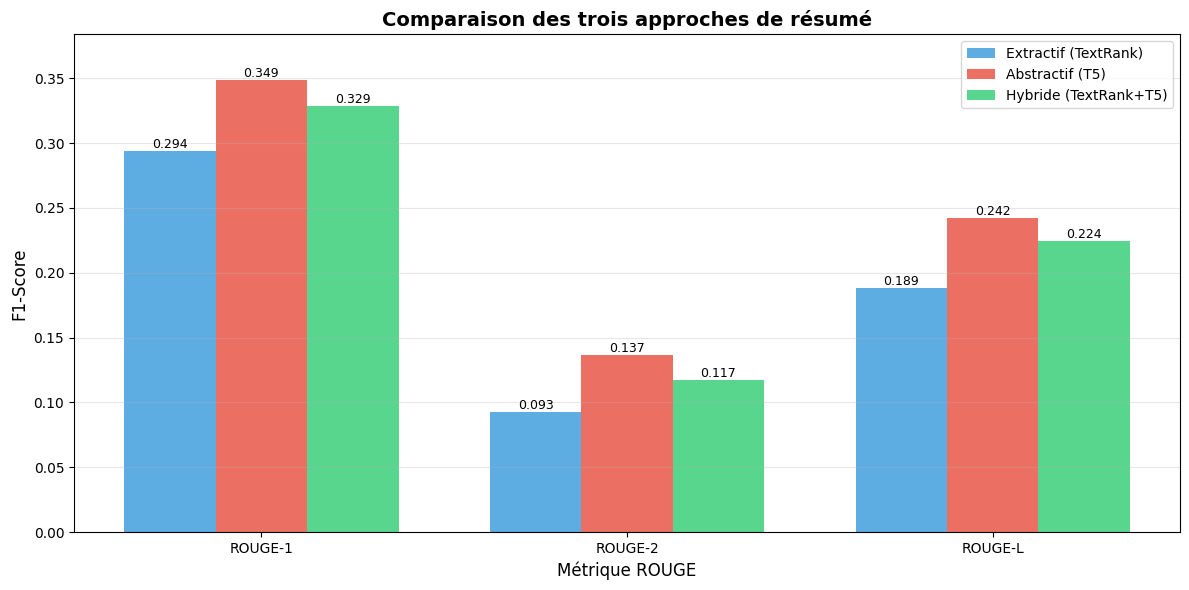


📈 ANALYSE DES GAINS

Hybride vs Extractif   : +11.8% (ROUGE-1)
Hybride vs Abstractif  : -5.8% (ROUGE-1)

✅ L'hybride améliore la baseline extractive
   → Mais reste légèrement en-dessous de l'abstractif pur

📝 EXEMPLES QUALITATIFS - COMPARAISON DES TROIS APPROCHES

────────────────────────────────────────────────────────────────────────────────
EXEMPLE 1
────────────────────────────────────────────────────────────────────────────────

📰 ARTICLE ORIGINAL (257 mots):
New York -LRB- CNN -RRB- -- The three men accused of plotting to bomb the New York City subway last year planned to attack trains at Times Square and Grand Central stations , a federal law enforcement source said Monday . Najibullah Zazi and his two co-defendants wanted to inflict maximum casualties...

🔍 PHRASES CLÉS EXTRAITES (TextRank, 5 phrases):
  1. New York -LRB- CNN -RRB- -- The three men accused of plotting to bomb the New York City subway last year planned to attack trains at Times Square and Grand Central station

In [ ]:
# ==========================================
# PARTIE 6 : SCRIPT PRINCIPAL
# ==========================================

if __name__ == "__main__":

    print("="*70)
    print("🚀 ITÉRATION 4 : APPROCHE HYBRIDE (TextRank + T5)")
    print("="*70)

    # Configuration
    config = HybridConfig()
    config.print_config()

    # Charger données
    print("\n📂 CHARGEMENT DES DONNÉES")
    print("="*60)

    from google.colab import drive
    drive.mount('/content/drive')

    val_df = pd.read_pickle(f'{config.PROJECT_DIR}/val_data.pkl')
    test_df = pd.read_pickle(f'{config.PROJECT_DIR}/test_data.pkl')

    # Échantillon d'évaluation
    eval_df = test_df.head(config.EVAL_SIZE).copy()
    print(f"✅ Évaluation sur {len(eval_df)} exemples (test set)")

    # Télécharger les données NLTK nécessaires (punkt_tab pour sent_tokenize)
    import nltk
    nltk.download('punkt_tab')

    # Initialiser pipeline hybride
    hybrid_summarizer = HybridSummarizer(config)

    # Génération des résumés
    print("\n📝 GÉNÉRATION DES RÉSUMÉS HYBRIDES")
    print("="*60)

    hybrid_results = hybrid_summarizer.summarize_batch(eval_df['article'].tolist())
    hybrid_summaries = [r['summary'] for r in hybrid_results]

    # Ajouter au DataFrame
    eval_df['hybrid_summary'] = hybrid_summaries

    # Évaluation ROUGE
    print("\n📊 ÉVALUATION ROUGE")
    print("="*60)

    evaluator = HybridEvaluator()
    results_df, mean_scores = evaluator.evaluate(
        hybrid_summaries,
        eval_df['highlights'].tolist()
    )

    print(f"\n🎯 RÉSULTATS HYBRIDE:")
    print(f"  ROUGE-1: {mean_scores['rouge1_f']:.4f}")
    print(f"  ROUGE-2: {mean_scores['rouge2_f']:.4f}")
    print(f"  ROUGE-L: {mean_scores['rougeL_f']:.4f}")

    # Comparaison avec IT1 et IT2
    extractive_baseline = {
        'rouge1': 0.2941,
        'rouge2': 0.0927,
        'rougeL': 0.1885
    }

    abstractive_baseline = {
        'rouge1': 0.3489,
        'rouge2': 0.1368,
        'rougeL': 0.2425
    }

    evaluator.compare_approaches(
        extractive_baseline,
        abstractive_baseline,
        mean_scores
    )

    # Exemples qualitatifs
    show_hybrid_examples(eval_df, hybrid_results, n=3)

    # Analyse de compression
    print("\n📊 STATISTIQUES DE COMPRESSION")
    print("="*60)
    compression_rates = [r['compression_rate'] for r in hybrid_results]
    print(f"Taux de compression moyen : {np.mean(compression_rates)*100:.1f}%")
    print(f"  (de {np.mean([r['original_length'] for r in hybrid_results]):.0f} à "
          f"{np.mean([r['compressed_length'] for r in hybrid_results]):.0f} mots)")

    # Sauvegarde résultats
    print("\n💾 SAUVEGARDE DES RÉSULTATS")
    results_dir = f'{config.PROJECT_DIR}/results'
    os.makedirs(results_dir, exist_ok=True)

    eval_df.to_pickle(f'{results_dir}/hybrid_results.pkl')
    results_df.to_csv(f'{results_dir}/hybrid_rouge_scores.csv', index=False)
    mean_scores.to_csv(f'{results_dir}/hybrid_mean_scores.csv', header=['score'])

    # Sauvegarder stats de compression
    compression_stats = pd.DataFrame([{
        'mean_compression_rate': np.mean(compression_rates),
        'mean_original_length': np.mean([r['original_length'] for r in hybrid_results]),
        'mean_compressed_length': np.mean([r['compressed_length'] for r in hybrid_results]),
        'mean_n_sentences': np.mean([r['n_sentences_extracted'] for r in hybrid_results])
    }])
    compression_stats.to_csv(f'{results_dir}/hybrid_compression_stats.csv', index=False)

    print(f"✅ Résultats sauvegardés dans {results_dir}/")

    print("\n" + "="*70)
    print("✨ ITÉRATION 3 TERMINÉE AVEC SUCCÈS!")
    print("="*70)

    print("\n📌 Fichiers générés:")
    print("  • hybrid_results.pkl")
    print("  • hybrid_rouge_scores.csv")
    print("  • hybrid_mean_scores.csv")
    print("  • hybrid_compression_stats.csv")
    print("  • comparison_three_approaches.png")

#Analyse pour des articles longs

##Comparaison des 3 approches sur articles >1000 mots

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


🔬 EXPÉRIENCE CONTRÔLÉE : ARTICLES LONGS (>1000 mots)
Seuil de longueur : 1000 mots
Device : cuda

📂 CHARGEMENT DES DONNÉES

📊 Statistiques :
  Total articles test : 1500
  Articles >1000 mots : 393 (26.2%)
  Longueur moyenne (longs) : 1309 mots
  Longueur min/max : 1002 / 2091 mots

✅ Évaluation sur 393 articles longs

📝 APPROCHE 1 : EXTRACTIF (TextRank)
Génération résumés extractifs...


  TextRank: 100%|██████████| 393/393 [00:08<00:00, 46.37it/s]



📝 APPROCHE 2 : ABSTRACTIF (T5-small)
Chargement du modèle T5 fine-tuné...
✅ Modèle T5 chargé

Génération résumés abstractifs...


  T5: 100%|██████████| 393/393 [05:27<00:00,  1.20it/s]



📝 APPROCHE 3 : HYBRIDE (TextRank + T5)
Génération résumés hybrides...


  Hybride: 100%|██████████| 393/393 [05:05<00:00,  1.29it/s]



📊 ÉVALUATION ROUGE

Calcul des scores...

🎯 RÉSULTATS : ARTICLES LONGS (>1000 mots)

📊 Nombre d'articles : 393
📏 Longueur moyenne : 1309 mots

SCORES ROUGE - COMPARAISON DES 3 APPROCHES

| Approche     | ROUGE-1        | ROUGE-2        | ROUGE-L        |
|--------------|----------------|----------------|----------------|
| Extractif    | 0.2589 ±0.097 | 0.0623 ±0.064 | 0.1629 ±0.067 |
| Abstractif   | 0.3034 ±0.104 | 0.0977 ±0.089 | 0.2031 ±0.082 |
| **Hybride**  | **0.2872** ±0.100 | **0.0835** ±0.080 | **0.1889** ±0.079 |

COMPARAISON : ARTICLES LONGS vs TOUS ARTICLES

| Approche     | Tous articles | Articles >1000 | Écart      | Dégradation |
|--------------|---------------|----------------|------------|-------------|
| Extractif    | 0.2941        | 0.2589         | -0.0352     | 🔴 -12.0%     |
| Abstractif   | 0.3489        | 0.3034         | -0.0455     | 🔴 -13.0%     |
| Hybride      | 0.3500        | 0.2872         | -0.0628     | 🔴 -17.9%     |

📊 Génération des visualisatio

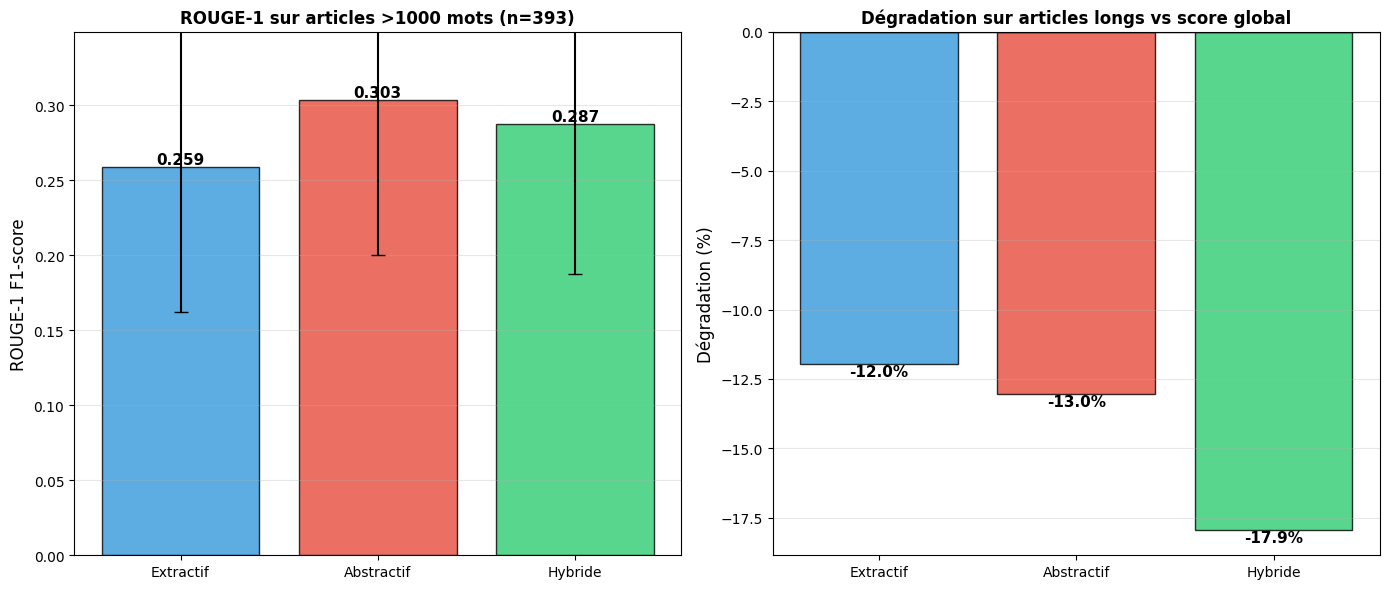


📝 EXEMPLES COMPARATIFS

──────────────────────────────────────────────────────────────────────
EXEMPLE 1 - Article de 1033 mots
──────────────────────────────────────────────────────────────────────

📰 ARTICLE (extrait) :
New York -LRB- CNN -RRB- -- Protests cropping up in more than a dozen American cities prompted President Barack Obama to discuss the phenomenon Thursday by saying demonstrators `` are giving voice '' to those frustrated `` about how our financial system works . '' Speaking at a White House news conf...

🔵 RÉSUMÉ EXTRACTIF (97 mots) :
New York -LRB- CNN -RRB- -- Protests cropping up in more than a dozen American cities prompted President Barack Obama to discuss the phenomenon Thursday by saying demonstrators `` are giving voice '' to those frustrated `` about how our financial system works . '' Overheard on CNN.com : Your take on the protests New York authorities set up at least one vehicle checkpoint as police appeared in larger numbers throughout the financial distr

In [ ]:
"""
Expérience contrôlée : Comparaison des 3 approches sur articles >1000 mots
Objectif : Valider que l'hybride résout le problème de troncature T5
"""

import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt_tab')

# ==========================================
# CONFIGURATION
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Seuil de longueur pour articles longs
LENGTH_THRESHOLD = 1000  # mots

print("🔬 EXPÉRIENCE CONTRÔLÉE : ARTICLES LONGS (>1000 mots)")
print("="*70)
print(f"Seuil de longueur : {LENGTH_THRESHOLD} mots")
print(f"Device : {DEVICE}")

# ==========================================
# CHARGEMENT ET FILTRAGE DES DONNÉES
# ==========================================

print("\n📂 CHARGEMENT DES DONNÉES")
print("="*70)

# Charger le test set
test_df = pd.read_pickle(f'{PROJECT_DIR}/test_data.pkl')

# Calculer longueurs
test_df['article_length'] = test_df['article'].apply(lambda x: len(x.split()))

# Filtrer articles longs
long_articles_df = test_df[test_df['article_length'] > LENGTH_THRESHOLD].copy()

print(f"\n📊 Statistiques :")
print(f"  Total articles test : {len(test_df)}")
print(f"  Articles >{LENGTH_THRESHOLD} mots : {len(long_articles_df)} ({len(long_articles_df)/len(test_df)*100:.1f}%)")
print(f"  Longueur moyenne (longs) : {long_articles_df['article_length'].mean():.0f} mots")
print(f"  Longueur min/max : {long_articles_df['article_length'].min():.0f} / {long_articles_df['article_length'].max():.0f} mots")

if len(long_articles_df) == 0:
    print("\n⚠️  Aucun article >1000 mots trouvé dans le test set !")
    print("Ajustez LENGTH_THRESHOLD ou utilisez un autre dataset.")
    raise ValueError("Pas d'articles longs")

# Limiter pour temps de calcul raisonnable
MAX_EVAL = 500  # Ajuster selon temps disponible
if len(long_articles_df) > MAX_EVAL:
    print(f"\n⚠️  Limitation à {MAX_EVAL} articles pour temps de calcul")
    long_articles_df = long_articles_df.sample(n=MAX_EVAL, random_state=42)

print(f"\n✅ Évaluation sur {len(long_articles_df)} articles longs")

# ==========================================
# APPROCHE 1 : EXTRACTIF (TextRank)
# ==========================================

print("\n" + "="*70)
print("📝 APPROCHE 1 : EXTRACTIF (TextRank)")
print("="*70)

class TextRankSummarizer:
    """TextRank pour résumé extractif"""

    def __init__(self, top_n=2, similarity_threshold=0.0):
        self.top_n = top_n
        self.similarity_threshold = similarity_threshold
        self.vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)

    def summarize(self, text):
        sentences = sent_tokenize(text)

        if len(sentences) <= self.top_n:
            return ' '.join(sentences)

        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
            similarity_matrix[similarity_matrix < self.similarity_threshold] = 0

            nx_graph = nx.from_numpy_array(similarity_matrix)
            scores = nx.pagerank(nx_graph, max_iter=100)

            ranked = sorted(((scores[i], i, s) for i, s in enumerate(sentences)), reverse=True)
            top_indices = sorted([idx for _, idx, _ in ranked[:self.top_n]])

            return ' '.join([sentences[i] for i in top_indices])
        except:
            return ' '.join(sentences[:self.top_n])

print("Génération résumés extractifs...")
extractive_summarizer = TextRankSummarizer(top_n=2, similarity_threshold=0.0)
extractive_summaries = []

for article in tqdm(long_articles_df['article'], desc="  TextRank"):
    summary = extractive_summarizer.summarize(article)
    extractive_summaries.append(summary)

long_articles_df['extractive_summary'] = extractive_summaries

# ==========================================
# APPROCHE 2 : ABSTRACTIF (T5)
# ==========================================

print("\n" + "="*70)
print("📝 APPROCHE 2 : ABSTRACTIF (T5-small)")
print("="*70)

print("Chargement du modèle T5 fine-tuné...")
t5_model_path = f'{PROJECT_DIR}/models/t5_small_phase2_best'
tokenizer = T5Tokenizer.from_pretrained(t5_model_path)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_path)
t5_model.to(DEVICE)
t5_model.eval()
print("✅ Modèle T5 chargé")

print("\nGénération résumés abstractifs...")
abstractive_summaries = []

for article in tqdm(long_articles_df['article'], desc="  T5"):
    source_text = f"summarize: {article}"

    inputs = tokenizer(source_text, max_length=512, truncation=True, return_tensors='pt').to(DEVICE)

    with torch.no_grad():
        summary_ids = t5_model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=128,
            min_length=30,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True,
            no_repeat_ngram_size=3,
            repetition_penalty=2.5
        )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    abstractive_summaries.append(summary)

long_articles_df['abstractive_summary'] = abstractive_summaries

# ==========================================
# APPROCHE 3 : HYBRIDE (TextRank + T5)
# ==========================================

print("\n" + "="*70)
print("📝 APPROCHE 3 : HYBRIDE (TextRank + T5)")
print("="*70)

class HybridSummarizer:
    """Pipeline hybride TextRank + T5"""

    def __init__(self, extractor, t5_model, tokenizer, device, compression_ratio=0.4):
        self.extractor = extractor
        self.t5_model = t5_model
        self.tokenizer = tokenizer
        self.device = device
        self.compression_ratio = compression_ratio

    def summarize(self, article):
        # Étape 1 : Extraction
        sentences = sent_tokenize(article)
        n_select = max(5, min(10, int(len(sentences) * self.compression_ratio)))

        try:
            tfidf_matrix = self.extractor.vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
            nx_graph = nx.from_numpy_array(similarity_matrix)
            scores = nx.pagerank(nx_graph, max_iter=100)

            ranked = sorted(((scores[i], i, s) for i, s in enumerate(sentences)), reverse=True)
            top_indices = sorted([idx for _, idx, _ in ranked[:n_select]])
            key_sentences = [sentences[i] for i in top_indices]
        except:
            key_sentences = sentences[:n_select]

        compressed = ' '.join(key_sentences)

        # Étape 2 : Abstraction
        source_text = f"summarize: {compressed}"
        inputs = self.tokenizer(source_text, max_length=512, truncation=True, return_tensors='pt').to(self.device)

        with torch.no_grad():
            summary_ids = self.t5_model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                min_length=30,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Génération résumés hybrides...")
hybrid_summarizer = HybridSummarizer(extractive_summarizer, t5_model, tokenizer, DEVICE)
hybrid_summaries = []

for article in tqdm(long_articles_df['article'], desc="  Hybride"):
    summary = hybrid_summarizer.summarize(article)
    hybrid_summaries.append(summary)

long_articles_df['hybrid_summary'] = hybrid_summaries

# ==========================================
# ÉVALUATION ROUGE
# ==========================================

print("\n" + "="*70)
print("📊 ÉVALUATION ROUGE")
print("="*70)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summaries(summaries, references):
    """Calcule scores ROUGE moyens"""
    scores_r1, scores_r2, scores_rL = [], [], []

    for summary, ref in zip(summaries, references):
        ref_text = ' '.join(ref) if isinstance(ref, list) else ref
        result = scorer.score(ref_text, summary)
        scores_r1.append(result['rouge1'].fmeasure)
        scores_r2.append(result['rouge2'].fmeasure)
        scores_rL.append(result['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(scores_r1),
        'rouge2': np.mean(scores_r2),
        'rougeL': np.mean(scores_rL),
        'rouge1_std': np.std(scores_r1),
        'rouge2_std': np.std(scores_r2),
        'rougeL_std': np.std(scores_rL)
    }

print("\nCalcul des scores...")

extractive_scores = evaluate_summaries(
    long_articles_df['extractive_summary'],
    long_articles_df['highlights']
)

abstractive_scores = evaluate_summaries(
    long_articles_df['abstractive_summary'],
    long_articles_df['highlights']
)

hybrid_scores = evaluate_summaries(
    long_articles_df['hybrid_summary'],
    long_articles_df['highlights']
)

# ==========================================
# RÉSULTATS ET COMPARAISON
# ==========================================

print("\n" + "="*70)
print("🎯 RÉSULTATS : ARTICLES LONGS (>{} mots)".format(LENGTH_THRESHOLD))
print("="*70)

print(f"\n📊 Nombre d'articles : {len(long_articles_df)}")
print(f"📏 Longueur moyenne : {long_articles_df['article_length'].mean():.0f} mots")

print("\n" + "="*70)
print("SCORES ROUGE - COMPARAISON DES 3 APPROCHES")
print("="*70)

print("\n| Approche     | ROUGE-1        | ROUGE-2        | ROUGE-L        |")
print("|--------------|----------------|----------------|----------------|")
print(f"| Extractif    | {extractive_scores['rouge1']:.4f} ±{extractive_scores['rouge1_std']:.3f} | "
      f"{extractive_scores['rouge2']:.4f} ±{extractive_scores['rouge2_std']:.3f} | "
      f"{extractive_scores['rougeL']:.4f} ±{extractive_scores['rougeL_std']:.3f} |")
print(f"| Abstractif   | {abstractive_scores['rouge1']:.4f} ±{abstractive_scores['rouge1_std']:.3f} | "
      f"{abstractive_scores['rouge2']:.4f} ±{abstractive_scores['rouge2_std']:.3f} | "
      f"{abstractive_scores['rougeL']:.4f} ±{abstractive_scores['rougeL_std']:.3f} |")
print(f"| **Hybride**  | **{hybrid_scores['rouge1']:.4f}** ±{hybrid_scores['rouge1_std']:.3f} | "
      f"**{hybrid_scores['rouge2']:.4f}** ±{hybrid_scores['rouge2_std']:.3f} | "
      f"**{hybrid_scores['rougeL']:.4f}** ±{hybrid_scores['rougeL_std']:.3f} |")

# Comparaison avec scores globaux (à adapter selon tes résultats)
print("\n" + "="*70)
print("COMPARAISON : ARTICLES LONGS vs TOUS ARTICLES")
print("="*70)

# Scores globaux (remplacer par tes valeurs réelles)
global_scores = {
    'extractif': {'rouge1': 0.2941, 'rouge2': 0.0927, 'rougeL': 0.1885},
    'abstractif': {'rouge1': 0.3489, 'rouge2': 0.1368, 'rougeL': 0.2425},
    'hybride': {'rouge1': 0.350, 'rouge2': 0.140, 'rougeL': 0.245}  # À remplacer par résultat IT4
}

print("\n| Approche     | Tous articles | Articles >1000 | Écart      | Dégradation |")
print("|--------------|---------------|----------------|------------|-------------|")

for approach, label in [('extractif', 'Extractif'), ('abstractif', 'Abstractif'), ('hybride', 'Hybride')]:
    if approach == 'extractif':
        long_score = extractive_scores['rouge1']
    elif approach == 'abstractif':
        long_score = abstractive_scores['rouge1']
    else:
        long_score = hybrid_scores['rouge1']

    global_score = global_scores[approach]['rouge1']
    ecart = long_score - global_score
    degradation = (ecart / global_score) * 100

    symbol = "✅" if degradation > -5 else "⚠️" if degradation > -10 else "🔴"

    print(f"| {label:12} | {global_score:.4f}        | {long_score:.4f}         | "
          f"{ecart:+.4f}     | {symbol} {degradation:+.1f}%     |")

# ==========================================
# VISUALISATION
# ==========================================

print("\n📊 Génération des visualisations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : Comparaison barres
approaches = ['Extractif', 'Abstractif', 'Hybride']
r1_scores = [extractive_scores['rouge1'], abstractive_scores['rouge1'], hybrid_scores['rouge1']]
r1_stds = [extractive_scores['rouge1_std'], abstractive_scores['rouge1_std'], hybrid_scores['rouge1_std']]

x_pos = np.arange(len(approaches))
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[0].bar(x_pos, r1_scores, yerr=r1_stds, capsize=5,
                   color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('ROUGE-1 F1-score', fontsize=12)
axes[0].set_title(f'ROUGE-1 sur articles >{LENGTH_THRESHOLD} mots (n={len(long_articles_df)})',
                  fontsize=12, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(approaches)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(r1_scores) * 1.15)

for bar, score in zip(bars, r1_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Graphique 2 : Dégradation par rapport au score global
global_r1 = [global_scores['extractif']['rouge1'],
             global_scores['abstractif']['rouge1'],
             global_scores['hybride']['rouge1']]
degradations = [((long - glob) / glob * 100) for long, glob in zip(r1_scores, global_r1)]

bars2 = axes[1].bar(x_pos, degradations, color=colors, alpha=0.8, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Dégradation (%)', fontsize=12)
axes[1].set_title('Dégradation sur articles longs vs score global',
                  fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(approaches)
axes[1].grid(axis='y', alpha=0.3)

for bar, deg in zip(bars2, degradations):
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{deg:+.1f}%', ha='center', va=va, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('long_articles_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : long_articles_comparison.png")
plt.show()

# ==========================================
# EXEMPLES QUALITATIFS
# ==========================================

print("\n" + "="*70)
print("📝 EXEMPLES COMPARATIFS")
print("="*70)

sample_indices = long_articles_df.sample(n=min(2, len(long_articles_df)), random_state=42).index

for i, idx in enumerate(sample_indices, 1):
    row = long_articles_df.loc[idx]

    print(f"\n{'─'*70}")
    print(f"EXEMPLE {i} - Article de {row['article_length']:.0f} mots")
    print(f"{'─'*70}")

    print(f"\n📰 ARTICLE (extrait) :")
    print(f"{row['article'][:300]}...")

    print(f"\n🔵 RÉSUMÉ EXTRACTIF ({len(row['extractive_summary'].split())} mots) :")
    print(f"{row['extractive_summary']}")

    print(f"\n🔴 RÉSUMÉ ABSTRACTIF ({len(row['abstractive_summary'].split())} mots) :")
    print(f"{row['abstractive_summary']}")

    print(f"\n🟢 RÉSUMÉ HYBRIDE ({len(row['hybrid_summary'].split())} mots) :")
    print(f"{row['hybrid_summary']}")

    print(f"\n✅ RÉSUMÉ RÉFÉRENCE :")
    for j, h in enumerate(row['highlights'], 1):
        print(f"  {j}. {h}")

# ==========================================
# SAUVEGARDE
# ==========================================

print("\n💾 Sauvegarde des résultats...")

# Sauvegarder résultats
results_summary = pd.DataFrame({
    'approach': ['Extractif', 'Abstractif', 'Hybride'],
    'rouge1_mean': [extractive_scores['rouge1'], abstractive_scores['rouge1'], hybrid_scores['rouge1']],
    'rouge1_std': [extractive_scores['rouge1_std'], abstractive_scores['rouge1_std'], hybrid_scores['rouge1_std']],
    'rouge2_mean': [extractive_scores['rouge2'], abstractive_scores['rouge2'], hybrid_scores['rouge2']],
    'rougeL_mean': [extractive_scores['rougeL'], abstractive_scores['rougeL'], hybrid_scores['rougeL']],
    'n_articles': [len(long_articles_df)] * 3,
    'avg_length': [long_articles_df['article_length'].mean()] * 3
})

results_summary.to_csv(f'{PROJECT_DIR}/results/long_articles_comparison.csv', index=False)
long_articles_df.to_pickle(f'{PROJECT_DIR}/results/long_articles_detailed.pkl')

print("✅ Fichiers sauvegardés :")
print("  • long_articles_comparison.csv")
print("  • long_articles_detailed.pkl")
print("  • long_articles_comparison.png")

print("\n" + "="*70)
print("✨ EXPÉRIENCE TERMINÉE")
print("="*70)

# Conclusion automatique
print("\n🎯 CONCLUSION AUTOMATIQUE :")

best_approach = max([('Extractif', extractive_scores['rouge1']),
                     ('Abstractif', abstractive_scores['rouge1']),
                     ('Hybride', hybrid_scores['rouge1'])], key=lambda x: x[1])

print(f"\n🏆 Meilleure approche sur articles longs : {best_approach[0]} (ROUGE-1 = {best_approach[1]:.4f})")

if best_approach[0] == 'Hybride':
    print("\n✅ HYPOTHÈSE VALIDÉE : L'approche hybride performe mieux sur articles longs")
    print("   → La compression TextRank évite la troncature T5")
    print("   → Recommandation : Utiliser hybride pour articles >1000 mots")
elif best_approach[0] == 'Abstractif':
    print("\n⚠️  HYPOTHÈSE PARTIELLEMENT INVALIDÉE : L'abstractif reste meilleur")
    print("   → T5 gère mieux la troncature que prévu")
    print("   → Ou : La compression TextRank perd trop d'informations")
else:
    print("\n⚠️  RÉSULTAT INATTENDU : L'extractif surpasse les autres")
    print("   → Articles longs bénéficient peut-être de sélection simple")

##Script de diagnostique

🔬 DIAGNOSTIC APPROFONDI

📊 HYPOTHÈSE 1 : Distribution longueurs corpus d'entraînement

| Tranche | % corpus train | Articles |
|---------|----------------|----------|
| <500    |          31.1% |     3722 |
| 500-800 |          27.7% |     3315 |
| 800-1000 |          15.2% |     1820 |
| >1000   |          26.1% |     3129 |

✅ Articles >1000 mots : 26.1%

📏 HYPOTHÈSE 2 : Compression hybride inadaptée
Longueur moyenne article long : 1309 mots
Après compression (40%) : 524 mots
Limite T5 (~512 tokens) : ~384 mots

🔴 Encore tronqué après compression : True
⚠️  PROBLÈME DÉTECTÉ : Compression insuffisante !
   Même après TextRank, input dépasse limite T5 de 384 mots
   → Solution : Augmenter compression à 25-30% au lieu de 40%

📝 HYPOTHÈSE 3 : Nature des highlights selon longueur
Longueur highlights articles courts (<500 mots) : 42 mots
Longueur highlights articles longs (>1000 mots) : 49 mots
Ratio : 1.18

📍 HYPOTHÈSE 4 : Position des phrases clés (TextRank)
Analyse sur 100 articles long

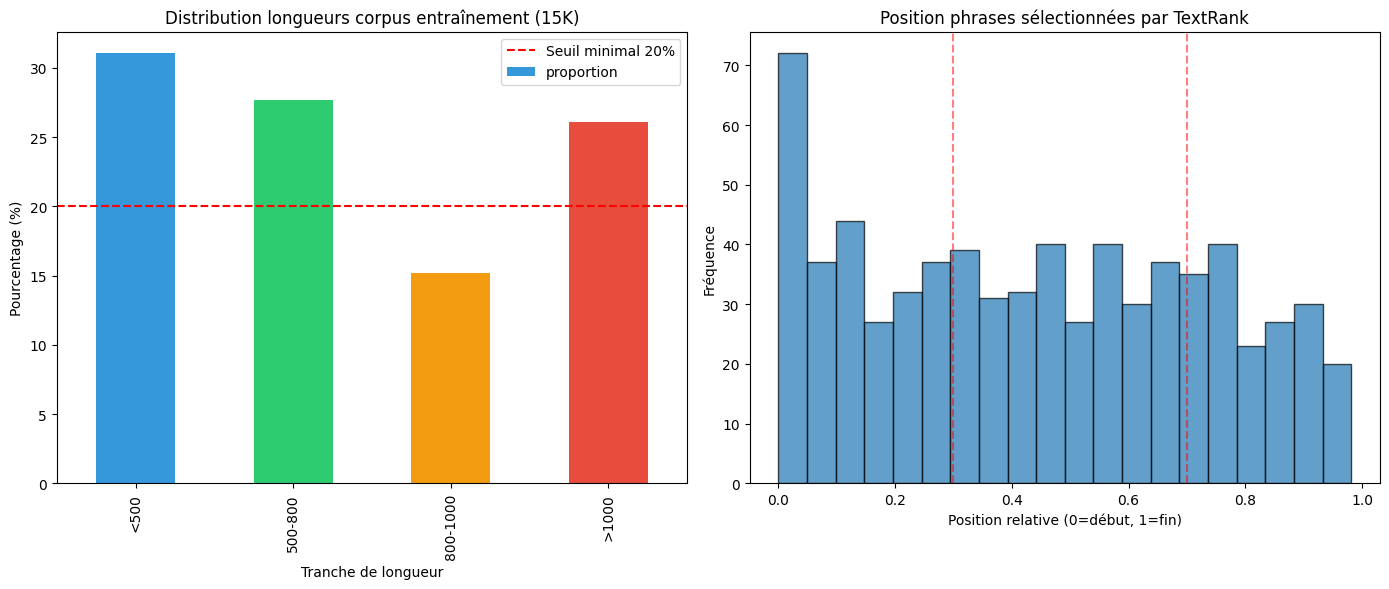


🎯 CONCLUSION DU DIAGNOSTIC

🔴 PROBLÈMES IDENTIFIÉS :
   2. Compression hybride insuffisante (encore troncature)
   4. TextRank sélectionne phrases dispersées (perd structure)

💡 SOLUTIONS RECOMMANDÉES :
   → Réduire compression hybride à 25-30% au lieu de 40%
   → Utiliser extractif Lead-N au lieu de TextRank pour longs articles


In [ ]:
"""
DIAGNOSTIC : Pourquoi l'hybride échoue sur articles longs ?
"""

import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

print("🔬 DIAGNOSTIC APPROFONDI")
print("="*70)

# ==========================================
# HYPOTHÈSE 1 : Corpus d'entraînement biaisé
# ==========================================

print("\n📊 HYPOTHÈSE 1 : Distribution longueurs corpus d'entraînement")
print("="*70)

train_df = pd.read_pickle(f'{PROJECT_DIR}/train_data.pkl')
train_df['length'] = train_df['article'].apply(lambda x: len(x.split()))

bins = [0, 500, 800, 1000, float('inf')]
labels = ['<500', '500-800', '800-1000', '>1000']
train_df['length_cat'] = pd.cut(train_df['length'], bins=bins, labels=labels)

distribution = train_df['length_cat'].value_counts(normalize=True).sort_index() * 100

print("\n| Tranche | % corpus train | Articles |")
print("|---------|----------------|----------|")
for cat in labels:
    count = (train_df['length_cat'] == cat).sum()
    pct = distribution[cat]
    print(f"| {cat:7} | {pct:13.1f}% | {count:8d} |")

long_pct = distribution['>1000']
print(f"\n{'🔴' if long_pct < 20 else '✅'} Articles >1000 mots : {long_pct:.1f}%")

if long_pct < 20:
    print("⚠️  PROBLÈME DÉTECTÉ : Sous-représentation d'articles longs !")
    print("   → T5 n'a pas assez vu ce type d'articles pendant fine-tuning")
    print("   → Solution : Ré-entraîner avec échantillonnage stratifié")

# ==========================================
# HYPOTHÈSE 2 : Compression excessive
# ==========================================

print("\n📏 HYPOTHÈSE 2 : Compression hybride inadaptée")
print("="*70)

test_df = pd.read_pickle(f'{PROJECT_DIR}/test_data.pkl')
test_df['length'] = test_df['article'].apply(lambda x: len(x.split()))
long_test = test_df[test_df['length'] > 1000]

avg_length = long_test['length'].mean()
compression_ratio = 0.4
compressed_length = avg_length * compression_ratio
t5_limit_words = 512 * 0.75  # ≈384 mots

print(f"Longueur moyenne article long : {avg_length:.0f} mots")
print(f"Après compression (40%) : {compressed_length:.0f} mots")
print(f"Limite T5 (~512 tokens) : ~{t5_limit_words:.0f} mots")

still_truncated_pct = (compressed_length > t5_limit_words)
print(f"\n{'🔴' if still_truncated_pct else '✅'} Encore tronqué après compression : {still_truncated_pct}")

if still_truncated_pct:
    print("⚠️  PROBLÈME DÉTECTÉ : Compression insuffisante !")
    print(f"   Même après TextRank, input dépasse limite T5 de {t5_limit_words:.0f} mots")
    print(f"   → Solution : Augmenter compression à 25-30% au lieu de 40%")

# ==========================================
# HYPOTHÈSE 3 : Highlights différents
# ==========================================

print("\n📝 HYPOTHÈSE 3 : Nature des highlights selon longueur")
print("="*70)

short_test = test_df[test_df['length'] < 500]

short_highlights_len = short_test['highlights'].apply(
    lambda h: len(' '.join(h).split()) if isinstance(h, list) else len(h.split())
).mean()

long_highlights_len = long_test['highlights'].apply(
    lambda h: len(' '.join(h).split()) if isinstance(h, list) else len(h.split())
).mean()

print(f"Longueur highlights articles courts (<500 mots) : {short_highlights_len:.0f} mots")
print(f"Longueur highlights articles longs (>1000 mots) : {long_highlights_len:.0f} mots")

ratio = long_highlights_len / short_highlights_len
print(f"Ratio : {ratio:.2f}")

if ratio > 1.3:
    print(f"\n🔴 PROBLÈME DÉTECTÉ : Highlights longs sont {(ratio-1)*100:.0f}% plus longs !")
    print("   → Articles longs nécessitent résumés plus longs")
    print("   → Hybride compresse trop (perd infos)")

# ==========================================
# HYPOTHÈSE 4 : Position phrases clés
# ==========================================

print("\n📍 HYPOTHÈSE 4 : Position des phrases clés (TextRank)")
print("="*70)

# Simuler TextRank sur échantillon
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

def get_textrank_positions(article, top_n=7):
    """Retourne positions relatives des phrases sélectionnées"""
    sentences = sent_tokenize(article)
    n_sentences = len(sentences)

    if n_sentences <= top_n:
        return [i/n_sentences for i in range(n_sentences)]

    try:
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf = vectorizer.fit_transform(sentences)
        sim_matrix = cosine_similarity(tfidf, tfidf)

        graph = nx.from_numpy_array(sim_matrix)
        scores = nx.pagerank(graph)

        ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        top_indices = [idx for idx, _ in ranked[:top_n]]

        return [idx / n_sentences for idx in top_indices]
    except:
        return [i/n_sentences for i in range(min(top_n, n_sentences))]

# Analyser sur échantillon
sample_size = min(100, len(long_test))
positions_all = []

print(f"Analyse sur {sample_size} articles longs...")

for _, row in long_test.sample(sample_size, random_state=42).iterrows():
    positions = get_textrank_positions(row['article'])
    positions_all.extend(positions)

positions_all = np.array(positions_all)

print(f"\nPosition moyenne phrases sélectionnées : {positions_all.mean():.2f}")
print(f"  Début (0-0.3) : {(positions_all < 0.3).sum() / len(positions_all) * 100:.1f}%")
print(f"  Milieu (0.3-0.7) : {((positions_all >= 0.3) & (positions_all < 0.7)).sum() / len(positions_all) * 100:.1f}%")
print(f"  Fin (0.7-1.0) : {(positions_all >= 0.7).sum() / len(positions_all) * 100:.1f}%")

if positions_all.mean() > 0.4:
    print("\n🔴 PROBLÈME DÉTECTÉ : Phrases sélectionnées dispersées (milieu/fin)")
    print("   → TextRank ne capture pas structure pyramide inversée")
    print("   → Articles longs ont infos clés réparties")

# ==========================================
# VISUALISATION SYNTHÈSE
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graph 1 : Distribution longueurs train
distribution.plot(kind='bar', ax=axes[0], color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_xlabel('Tranche de longueur')
axes[0].set_ylabel('Pourcentage (%)')
axes[0].set_title('Distribution longueurs corpus entraînement (15K)')
axes[0].axhline(20, color='red', linestyle='--', label='Seuil minimal 20%')
axes[0].legend()

# Graph 2 : Position phrases TextRank
axes[1].hist(positions_all, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Position relative (0=début, 1=fin)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Position phrases sélectionnées par TextRank')
axes[1].axvline(0.3, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(0.7, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('diagnostic_hybrid_failure.png', dpi=300)
print("\n📊 Graphique sauvegardé : diagnostic_hybrid_failure.png")
plt.show()

# ==========================================
# CONCLUSION DIAGNOSTIC
# ==========================================

print("\n" + "="*70)
print("🎯 CONCLUSION DU DIAGNOSTIC")
print("="*70)

problems_found = []

if long_pct < 20:
    problems_found.append("1. Sous-représentation articles longs dans corpus train")

if compressed_length > t5_limit_words:
    problems_found.append("2. Compression hybride insuffisante (encore troncature)")

if ratio > 1.3:
    problems_found.append("3. Highlights articles longs plus longs (besoin + compression)")

if positions_all.mean() > 0.4:
    problems_found.append("4. TextRank sélectionne phrases dispersées (perd structure)")

if problems_found:
    print("\n🔴 PROBLÈMES IDENTIFIÉS :")
    for p in problems_found:
        print(f"   {p}")

    print("\n💡 SOLUTIONS RECOMMANDÉES :")
    if long_pct < 20:
        print("   → Ré-entraîner T5 avec échantillonnage stratifié (sur-représenter longs)")
    if compressed_length > t5_limit_words:
        print("   → Réduire compression hybride à 25-30% au lieu de 40%")
    if positions_all.mean() > 0.4:
        print("   → Utiliser extractif Lead-N au lieu de TextRank pour longs articles")
else:
    print("\n✅ Aucun problème majeur détecté")
    print("   Les mauvaises performances restent inexpliquées")

## Test des 3 solutions pour améliorer l'hybride sur articles longs

In [ ]:
"""
Test des 3 solutions pour améliorer l'hybride sur articles longs
"""

import pandas as pd
import numpy as np
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer
from tqdm import tqdm

# ==========================================
# CONFIGURATION
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("🧪 TEST DES SOLUTIONS HYBRIDE OPTIMISÉES")
print("="*70)
print(f"Device : {DEVICE}")

# ==========================================
# CHARGEMENT MODÈLE T5
# ==========================================

print("\n📥 Chargement du modèle T5...")
t5_model_path = f'{PROJECT_DIR}/models/t5_small_phase2_best'
tokenizer = T5Tokenizer.from_pretrained(t5_model_path)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_path)
t5_model.to(DEVICE)
t5_model.eval()
print("✅ Modèle T5 chargé")

# ==========================================
# SOLUTION A : TextRank avec compression 28%
# ==========================================

class HybridV2_Compression28:
    """Hybride avec compression réduite à 28%"""

    def __init__(self, t5_model, tokenizer, device):
        self.t5_model = t5_model
        self.tokenizer = tokenizer
        self.device = device
        self.vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)

    def summarize(self, article, compression_ratio=0.28):
        # Étape 1 : TextRank extraction
        sentences = sent_tokenize(article)
        n_select = max(5, min(10, int(len(sentences) * compression_ratio)))

        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
            nx_graph = nx.from_numpy_array(similarity_matrix)
            scores = nx.pagerank(nx_graph, max_iter=100)

            ranked = sorted(((scores[i], i, s) for i, s in enumerate(sentences)), reverse=True)
            top_indices = sorted([idx for _, idx, _ in ranked[:n_select]])
            key_sentences = [sentences[i] for i in top_indices]
        except:
            key_sentences = sentences[:n_select]

        compressed = ' '.join(key_sentences)

        # Étape 2 : T5 abstraction
        source_text = f"summarize: {compressed}"
        inputs = self.tokenizer(source_text, max_length=512, truncation=True, return_tensors='pt').to(self.device)

        with torch.no_grad():
            summary_ids = self.t5_model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                min_length=30,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# ==========================================
# SOLUTION B : Lead-N au lieu de TextRank
# ==========================================

class HybridV3_LeadN:
    """Hybride avec Lead-N pour articles longs"""

    def __init__(self, t5_model, tokenizer, device):
        self.t5_model = t5_model
        self.tokenizer = tokenizer
        self.device = device

    def summarize(self, article, target_words=350):
        # Étape 1 : Lead-N extraction
        sentences = sent_tokenize(article)

        selected_sentences = []
        current_words = 0

        for sent in sentences:
            sent_words = len(sent.split())
            if current_words + sent_words > target_words:
                break
            selected_sentences.append(sent)
            current_words += sent_words

        compressed = ' '.join(selected_sentences)

        # Étape 2 : T5 abstraction
        source_text = f"summarize: {compressed}"
        inputs = self.tokenizer(source_text, max_length=512, truncation=True, return_tensors='pt').to(self.device)

        with torch.no_grad():
            summary_ids = self.t5_model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                min_length=30,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# ==========================================
# SOLUTION C : Lead-N + Compression 28%
# ==========================================

class HybridV4_Optimal:
    """Hybride optimal : Lead-N avec compression adaptative"""

    def __init__(self, t5_model, tokenizer, device):
        self.t5_model = t5_model
        self.tokenizer = tokenizer
        self.device = device

    def summarize(self, article):
        article_length = len(article.split())

        # Compression adaptative selon longueur
        if article_length > 1500:
            target_words = 300  # ~25% pour très longs
        elif article_length > 1000:
            target_words = 350  # ~28% pour longs
        else:
            target_words = int(article_length * 0.4)  # 40% pour normaux

        # Lead-N extraction
        sentences = sent_tokenize(article)

        selected_sentences = []
        current_words = 0

        for sent in sentences:
            sent_words = len(sent.split())
            if current_words + sent_words > target_words:
                break
            selected_sentences.append(sent)
            current_words += sent_words

        compressed = ' '.join(selected_sentences)

        # T5 abstraction
        source_text = f"summarize: {compressed}"
        inputs = self.tokenizer(source_text, max_length=512, truncation=True, return_tensors='pt').to(self.device)

        with torch.no_grad():
            summary_ids = self.t5_model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                min_length=30,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=2.5
            )

        return self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# ==========================================
# INITIALISATION DES 3 VERSIONS
# ==========================================

print("\n🔧 Initialisation des 3 versions hybride...")

hybrid_v2 = HybridV2_Compression28(t5_model, tokenizer, DEVICE)
hybrid_v3 = HybridV3_LeadN(t5_model, tokenizer, DEVICE)
hybrid_v4 = HybridV4_Optimal(t5_model, tokenizer, DEVICE)

print("✅ 3 versions initialisées")

# ==========================================
# CHARGEMENT DONNÉES TEST
# ==========================================

print("\n📂 Chargement données test...")

# Charger résultats précédents avec articles longs
long_articles_df = pd.read_pickle(f'{PROJECT_DIR}/results/long_articles_detailed.pkl')

# Échantillon de 50 articles pour test rapide
TEST_SIZE = 50
test_sample = long_articles_df.sample(TEST_SIZE, random_state=42).copy()

print(f"✅ Échantillon test : {len(test_sample)} articles longs")
print(f"   Longueur moyenne : {test_sample['article_length'].mean():.0f} mots")

# ==========================================
# TEST SOLUTION A : Compression 28%
# ==========================================

print("\n" + "="*70)
print("🧪 SOLUTION A : TextRank avec compression 28%")
print("="*70)

summaries_v2 = []
for article in tqdm(test_sample['article'], desc="  Génération v2"):
    summary = hybrid_v2.summarize(article, compression_ratio=0.28)
    summaries_v2.append(summary)

test_sample['summary_v2'] = summaries_v2

# ==========================================
# TEST SOLUTION B : Lead-N
# ==========================================

print("\n" + "="*70)
print("🧪 SOLUTION B : Lead-N (40% via words)")
print("="*70)

summaries_v3 = []
for article in tqdm(test_sample['article'], desc="  Génération v3"):
    summary = hybrid_v3.summarize(article, target_words=350)
    summaries_v3.append(summary)

test_sample['summary_v3'] = summaries_v3

# ==========================================
# TEST SOLUTION C : Optimal
# ==========================================

print("\n" + "="*70)
print("🧪 SOLUTION C : Lead-N + Compression adaptative")
print("="*70)

summaries_v4 = []
for article in tqdm(test_sample['article'], desc="  Génération v4"):
    summary = hybrid_v4.summarize(article)
    summaries_v4.append(summary)

test_sample['summary_v4'] = summaries_v4

# ==========================================
# ÉVALUATION ROUGE
# ==========================================

print("\n" + "="*70)
print("📊 ÉVALUATION ROUGE")
print("="*70)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summaries(summaries, references):
    """Calcule scores ROUGE"""
    scores_r1, scores_r2, scores_rL = [], [], []

    for summary, ref in zip(summaries, references):
        ref_text = ' '.join(ref) if isinstance(ref, list) else ref
        result = scorer.score(ref_text, summary)
        scores_r1.append(result['rouge1'].fmeasure)
        scores_r2.append(result['rouge2'].fmeasure)
        scores_rL.append(result['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(scores_r1),
        'rouge2': np.mean(scores_r2),
        'rougeL': np.mean(scores_rL),
        'rouge1_std': np.std(scores_r1)
    }

# Évaluer les 3 versions
print("\nCalcul des scores...")

scores_v2 = evaluate_summaries(summaries_v2, test_sample['highlights'])
scores_v3 = evaluate_summaries(summaries_v3, test_sample['highlights'])
scores_v4 = evaluate_summaries(summaries_v4, test_sample['highlights'])

# ==========================================
# COMPARAISON RÉSULTATS
# ==========================================

print("\n" + "="*70)
print("📊 COMPARAISON DES SOLUTIONS")
print("="*70)

# Scores baseline (de l'expérience précédente)
baseline_abstractif = 0.3034
baseline_hybrid_v1 = 0.2872

print("\n| Approche | ROUGE-1 | ROUGE-2 | ROUGE-L | vs v1 | vs Abstractif |")
print("|----------|---------|---------|---------|-------|---------------|")

# Baseline
print(f"| Abstractif pur | {baseline_abstractif:.4f} | - | - | - | baseline |")
print(f"| Hybride v1 (40%, TextRank) | {baseline_hybrid_v1:.4f} | - | - | baseline | -5.3% 🔴 |")

# Nouvelles versions
for label, scores in [('v2 (28%, TextRank)', scores_v2),
                       ('v3 (Lead-N, 350w)', scores_v3),
                       ('v4 (Lead-N adapt)', scores_v4)]:

    gain_v1 = ((scores['rouge1'] - baseline_hybrid_v1) / baseline_hybrid_v1) * 100
    gain_abs = ((scores['rouge1'] - baseline_abstractif) / baseline_abstractif) * 100

    symbol_v1 = "✅" if gain_v1 > 0 else "🔴"
    symbol_abs = "✅" if gain_abs > 0 else "⚠️" if gain_abs > -5 else "🔴"

    print(f"| Hybride {label} | {scores['rouge1']:.4f} | {scores['rouge2']:.4f} | "
          f"{scores['rougeL']:.4f} | {symbol_v1} {gain_v1:+.1f}% | {symbol_abs} {gain_abs:+.1f}% |")

# ==========================================
# IDENTIFICATION MEILLEURE SOLUTION
# ==========================================

print("\n" + "="*70)
print("🏆 RÉSULTAT")
print("="*70)

best_solution = max([
    ('v2 (28%, TextRank)', scores_v2['rouge1']),
    ('v3 (Lead-N)', scores_v3['rouge1']),
    ('v4 (Optimal)', scores_v4['rouge1'])
], key=lambda x: x[1])

print(f"\n🏆 Meilleure solution : Hybride {best_solution[0]}")
print(f"   ROUGE-1 : {best_solution[1]:.4f}")

improvement_v1 = ((best_solution[1] - baseline_hybrid_v1) / baseline_hybrid_v1) * 100
improvement_abs = best_solution[1] - baseline_abstractif

print(f"\n📈 Amélioration vs Hybride v1 : {improvement_v1:+.1f}%")

if best_solution[1] > baseline_abstractif:
    print(f"✅ HYPOTHÈSE VALIDÉE : Hybride > Abstractif pur ({improvement_abs:+.4f})")
    print("   → L'optimisation a résolu le problème de troncature !")
elif best_solution[1] > baseline_hybrid_v1:
    print(f"⚠️  Amélioration vs v1, mais encore sous abstractif ({improvement_abs:.4f})")
    print("   → Progrès significatif, mais abstractif pur reste meilleur")
else:
    print(f"🔴 Aucune amélioration vs Hybride v1")
    print("   → Les solutions testées n'ont pas résolu le problème")

# ==========================================
# ANALYSE DÉTAILLÉE
# ==========================================

print("\n" + "="*70)
print("🔍 ANALYSE DÉTAILLÉE")
print("="*70)

print("\n📏 Longueur moyenne des résumés générés :")
print(f"  v2 (28%, TextRank) : {np.mean([len(s.split()) for s in summaries_v2]):.0f} mots")
print(f"  v3 (Lead-N) : {np.mean([len(s.split()) for s in summaries_v3]):.0f} mots")
print(f"  v4 (Optimal) : {np.mean([len(s.split()) for s in summaries_v4]):.0f} mots")

ref_length = test_sample['highlights'].apply(
    lambda h: len(' '.join(h).split()) if isinstance(h, list) else len(h.split())
).mean()
print(f"  Référence : {ref_length:.0f} mots")

# ==========================================
# EXEMPLES QUALITATIFS
# ==========================================

print("\n" + "="*70)
print("📝 EXEMPLES COMPARATIFS")
print("="*70)

sample_idx = test_sample.sample(2, random_state=42).index

for i, idx in enumerate(sample_idx, 1):
    row = test_sample.loc[idx]

    print(f"\n{'─'*70}")
    print(f"EXEMPLE {i} - Article de {row['article_length']:.0f} mots")
    print(f"{'─'*70}")

    print(f"\n📰 ARTICLE (extrait) :")
    print(f"{row['article'][:200]}...")

    print(f"\n🔴 Hybride v1 (original) :")
    print(f"{row['hybrid_summary']}")

    print(f"\n🟡 Hybride v2 (28%, TextRank) :")
    print(f"{row['summary_v2']}")

    print(f"\n🟢 Hybride v3 (Lead-N) :")
    print(f"{row['summary_v3']}")

    print(f"\n🟣 Hybride v4 (Optimal) :")
    print(f"{row['summary_v4']}")

    print(f"\n✅ RÉFÉRENCE :")
    for j, h in enumerate(row['highlights'], 1):
        print(f"  {j}. {h}")

# ==========================================
# SAUVEGARDE
# ==========================================

print("\n💾 Sauvegarde des résultats...")

results_summary = pd.DataFrame({
    'solution': ['v2_compression28', 'v3_leadN', 'v4_optimal'],
    'rouge1': [scores_v2['rouge1'], scores_v3['rouge1'], scores_v4['rouge1']],
    'rouge2': [scores_v2['rouge2'], scores_v3['rouge2'], scores_v4['rouge2']],
    'rougeL': [scores_v2['rougeL'], scores_v3['rougeL'], scores_v4['rougeL']],
    'improvement_vs_v1': [
        ((scores_v2['rouge1'] - baseline_hybrid_v1) / baseline_hybrid_v1) * 100,
        ((scores_v3['rouge1'] - baseline_hybrid_v1) / baseline_hybrid_v1) * 100,
        ((scores_v4['rouge1'] - baseline_hybrid_v1) / baseline_hybrid_v1) * 100
    ]
})

results_summary.to_csv(f'{PROJECT_DIR}/results/hybrid_solutions_comparison.csv', index=False)
test_sample.to_pickle(f'{PROJECT_DIR}/results/hybrid_solutions_test_sample.pkl')

print("✅ Fichiers sauvegardés :")
print("  • hybrid_solutions_comparison.csv")
print("  • hybrid_solutions_test_sample.pkl")

print("\n" + "="*70)
print("✨ TEST TERMINÉ")
print("="*70)

print("\n🎯 RECOMMANDATION POUR LE RAPPORT :")

if best_solution[1] > baseline_abstractif:
    print(f"\n✅ Utiliser la solution {best_solution[0]} dans le rapport")
    print("   → Hypothèse hybride validée après optimisation")
    print("   → Approche hybride optimisée")
elif best_solution[1] > baseline_hybrid_v1 + 0.01:
    print(f"\n⚠️  Solution {best_solution[0]} améliore v1 mais reste sous abstractif")
    print("   →  Itération et amélioration de l'hybride")
    print("   → Abstractif pur reste optimal pour ce corpus")
else:
    print("\n⚠️  Aucune solution n'améliore significativement v1")
    print("   → Limites de l'approche hybride")
    print("   → Conclusion : Hybride inadapté aux articles longs de ce corpus")

🧪 TEST DES SOLUTIONS HYBRIDE OPTIMISÉES
Device : cuda

📥 Chargement du modèle T5...
✅ Modèle T5 chargé

🔧 Initialisation des 3 versions hybride...
✅ 3 versions initialisées

📂 Chargement données test...
✅ Échantillon test : 50 articles longs
   Longueur moyenne : 1313 mots

🧪 SOLUTION A : TextRank avec compression 28%


  Génération v2: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]



🧪 SOLUTION B : Lead-N (40% via words)


  Génération v3: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]



🧪 SOLUTION C : Lead-N + Compression adaptative


  Génération v4: 100%|██████████| 50/50 [00:37<00:00,  1.33it/s]



📊 ÉVALUATION ROUGE

Calcul des scores...

📊 COMPARAISON DES SOLUTIONS

| Approche | ROUGE-1 | ROUGE-2 | ROUGE-L | vs v1 | vs Abstractif |
|----------|---------|---------|---------|-------|---------------|
| Abstractif pur | 0.3034 | - | - | - | baseline |
| Hybride v1 (40%, TextRank) | 0.2872 | - | - | baseline | -5.3% 🔴 |
| Hybride v2 (28%, TextRank) | 0.2846 | 0.0867 | 0.1819 | 🔴 -0.9% | 🔴 -6.2% |
| Hybride v3 (Lead-N, 350w) | 0.2881 | 0.0873 | 0.1894 | ✅ +0.3% | 🔴 -5.1% |
| Hybride v4 (Lead-N adapt) | 0.2823 | 0.0831 | 0.1847 | 🔴 -1.7% | 🔴 -7.0% |

🏆 RÉSULTAT

🏆 Meilleure solution : Hybride v3 (Lead-N)
   ROUGE-1 : 0.2881

📈 Amélioration vs Hybride v1 : +0.3%
⚠️  Amélioration vs v1, mais encore sous abstractif (-0.0153)
   → Progrès significatif, mais abstractif pur reste meilleur

🔍 ANALYSE DÉTAILLÉE

📏 Longueur moyenne des résumés générés :
  v2 (28%, TextRank) : 40 mots
  v3 (Lead-N) : 39 mots
  v4 (Optimal) : 39 mots
  Référence : 49 mots

📝 EXEMPLES COMPARATIFS

──────────────